#Uso de series difusas para el desarrollo de modelos de predicción de demandas de la energía eléctrica.

**Estudiante: José Manuel Rubio Cienfuegos.**

**Prof. José Miguel Rubio León.**

**Prof coguía: Francisco Rivera.**

El siguiente notebook contiene el sistema encargado de procesar la base de datos que contiene información sobre diversos consumos de energía, además de datos sobre las variables que afectan este consumo de energía.

##Librerías

Esta celda contiene información sobre todas librerías necesarias para el procesamiento de la información y exposición de los resultados obtenidos.

In [5]:
# Procesamiento de datos y gráficos.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modelos de ML clásicos.
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from statsmodels.tsa.arima_model import ARIMA

# Métricas
from sklearn.metrics import mean_squared_error, max_error, mean_absolute_error

# MAPE Function

def MAPE(y_true, y_pred):
  true_length, pred_length = y_true.__len__(), y_pred.__len__()
  assert true_length == pred_length, ('Lengths of arrays are differents, y_true have ' + str(true_length) + ' values and y_pred have ' + str(pred_length) + ' values.')
  return (100*(sum(abs((y_true - y_pred)/(y_true)))))/(y_true.__len__())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
# !git clone https://github.com/JossRubio/Prediccion_demanda_energetica

##Carga de datos

Los datos a utilizar se cargan en este bloque. Previo a esto se deben haber subido a la interfaz de colab o habilitar un link de algun servidor para cargarlos de manera remota. En el siguiente bloque se pueden subir los archivos de forma local

Con los archivos subidos, entonces se cargan dentro del notebook

In [7]:
# Extracción de datasets
df_energy = pd.read_csv('energy_dataset.csv')
df_weather = pd.read_csv('weather_features.csv')

In [8]:
df_energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [9]:
df_weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


Antes de desarrollar algun modelo, se debe destacar que dentro de los datos ya se cuentan con valores predichos para la demanda. Por ello esta celda indica cual es el **MAPE** (*Mean Absolute Percentage Error*) de los datos pronosticados guardados en el dataset *energy_dataset.csv*

In [10]:
df_demand = df_energy[['total load actual', 'total load forecast']].dropna() # Eliminación de nans presentes en la columna de valores de la demanda.
demand_total, demand_forecast = df_demand['total load actual'], df_demand['total load forecast']

# MAPE de los valores predichos en la demanda del dataset original.
MAPE_goal = MAPE(demand_total.values, demand_forecast.values)
print('The MAPE of the work is:', round(MAPE_goal, 3), '%') 

The MAPE of the work is: 1.096 %


In [11]:
df_energy.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')

In [12]:
''' ANALIZAR SI LOS VALORES DE GENERACIÓN DE DISTINTOS TIPOS DE ENERGÍA EQUIVALE A LA DEMANDA TOTAL MOSTRADA EN EL DATASET. '''
# Suma de valores de la columna del dataset de energia (energy_dataset.csv)

# En primer lugar se quieren eliminar aquellas columnas que en su mayoría poseen valores nans. Para ello se diseña la siguiente función

def nans_remove(df, nan_threshold, reset_index=True):
  df_process = df.copy()
  assert nan_threshold < 1 and nan_threshold > 0 , ('nan threshold must be between 0 and 1')
  cols_names = df.columns
  # print(cols_names)
  for name in cols_names:
    len, drop_len = df_process[name].__len__(), df_process[name].dropna().__len__()
    difference_reason = (len - drop_len)/(len)
    # print(difference_reason)
    if difference_reason > (1-nan_threshold):
      # print(name)
      df_process.drop(columns=[name], inplace=True)
    else:
      continue
  df_process.dropna(inplace=True)
  df_process.reset_index(drop=reset_index, inplace=reset_index)
  return df_process

nan_limit = .9

# Eliminando las columnas nans del dataframe se tiene.
df_energy_processed = nans_remove(df_energy, nan_limit)

# Obteniendo las columnas que solo poseen valores de generación
columns_drop = ['forecast solar day ahead', 'forecast wind onshore day ahead','price day ahead', 'price actual']
columns_demand = ['total load forecast','total load actual']
demand_data, time_data = df_energy_processed[columns_demand], df_energy_processed['time']

df_generation = df_energy_processed.drop(columns=columns_drop + columns_demand)
generation_values = df_generation.values

# Sumando los valores numericos del dataframe procesado, y añadiendo la columna al dataframe original
generation_total = df_generation.sum(axis=1, numeric_only=True)
generation_total.name = 'Generation total'

df_gen_dem = pd.concat([time_data, generation_total, demand_data], axis=1)
# df_gen_dem.set_index('time', inplace=True)
df_gen_dem.head()

,time,Generation total,total load forecast,total load actual
0,2015-01-01 00:00:00+01:00,28251.0,26118.0,25385.0
1,2015-01-01 01:00:00+01:00,27818.0,24934.0,24382.0
2,2015-01-01 02:00:00+01:00,26796.0,23515.0,22734.0
3,2015-01-01 03:00:00+01:00,25223.0,22642.0,21286.0
4,2015-01-01 04:00:00+01:00,24620.0,21785.0,20264.0


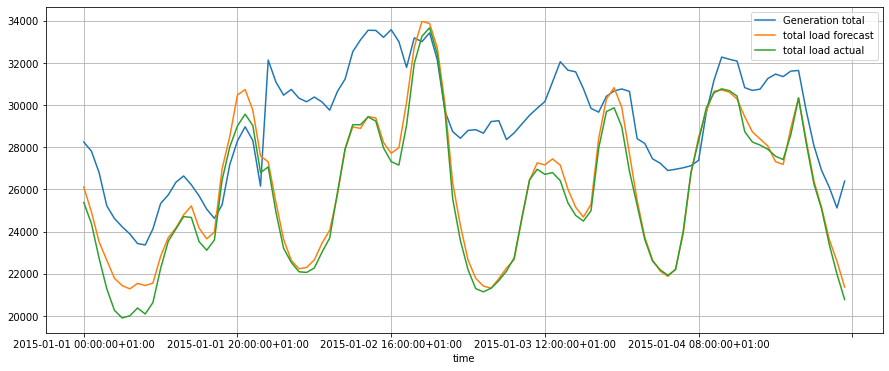

In [13]:
df_gen_dem.iloc[:100].plot(x='time', figsize=(15,6), grid=True)

In [14]:
df_energy

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,NaN,1.0,1135.0,4836.0,0.0,6073.0,63.0,95.0,85.0,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,NaN,1.0,1172.0,3931.0,0.0,6074.0,62.0,95.0,33.0,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,NaN,50.0,1148.0,2831.0,0.0,6076.0,61.0,94.0,31.0,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,NaN,108.0,1128.0,2068.0,0.0,6075.0,61.0,93.0,31.0,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89


In [15]:
energy_values = df_energy.values
generation_values, demand_values = energy_values[:,1:-7], demand_total.values
generation_values.shape

(35064, 21)

In [16]:
df_energy

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,NaN,1.0,1135.0,4836.0,0.0,6073.0,63.0,95.0,85.0,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,NaN,1.0,1172.0,3931.0,0.0,6074.0,62.0,95.0,33.0,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,NaN,50.0,1148.0,2831.0,0.0,6076.0,61.0,94.0,31.0,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,NaN,108.0,1128.0,2068.0,0.0,6075.0,61.0,93.0,31.0,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89


In [17]:
generation_values

array([[447.0, 329.0, 0.0, ..., 196.0, 0.0, 6378.0],
       [449.0, 328.0, 0.0, ..., 195.0, 0.0, 5890.0],
       [448.0, 323.0, 0.0, ..., 196.0, 0.0, 5461.0],
       ...,
       [292.0, 0.0, 0.0, ..., 286.0, 0.0, 3503.0],
       [293.0, 0.0, 0.0, ..., 287.0, 0.0, 3586.0],
       [290.0, 0.0, 0.0, ..., 287.0, 0.0, 3651.0]], dtype=object)

## Extracción de variables estocásticas de interes para la demanda de la energía eléctrica.

Una parte importante de este trabajo es la búsqueda de las características que más afectan a la demanda de la energía eléctrica, donde se espera que estas esten presentes dentro de la base de datos. Para ellos se realiza una búsqueda de cuales son las variables que más influyen en los valores presentes en la demanda de la energía.

En primer lugar se realizará un análisis inmediato sobre las generaciones en el dataset que contiene la demanda

In [18]:
df_gen_dem.head()

,time,Generation total,total load forecast,total load actual
0,2015-01-01 00:00:00+01:00,28251.0,26118.0,25385.0
1,2015-01-01 01:00:00+01:00,27818.0,24934.0,24382.0
2,2015-01-01 02:00:00+01:00,26796.0,23515.0,22734.0
3,2015-01-01 03:00:00+01:00,25223.0,22642.0,21286.0
4,2015-01-01 04:00:00+01:00,24620.0,21785.0,20264.0


## Series Temporales

En esta sección se procesa la información de la base de datos para realizar las predicciones mediante el uso de series temporales clásicas.

In [167]:
# Procesamiento de la data para el uso de regresores clásicos de ML.

demand_serie = df_gen_dem[['time', 'total load forecast', 'total load actual']]

# Función para la generación de series temporales, cuyo largo se puede configurar.

def series_constructor(df, len_serie, column_serie, column_concat_name=None, dropna=True, reset_index=True):
  df_process = df[column_serie]
  df_out = pd.DataFrame() if column_concat_name == None else df[column_concat_name]
  for k in reversed(range(len_serie + 1)):
    serie_moved = df_process.shift(k)
    serie_moved.name = 't-' + str(k)
    df_out = pd.concat([df_out, serie_moved], axis=1)
  df_out.rename(columns={'t-0':'t'}, inplace=True)
  columns_final = list(df_out.columns) if column_concat_name == None else list(df_out.columns)[1:] + [column_concat_name]
  df_out = df_out[columns_final]
  df_out.dropna(inplace=dropna)
  df_out.reset_index(drop=reset_index, inplace=reset_index)
  return df_out

# Procesamiento de la información de la demanda con la función anterior

length_serie = 24       # Como la serie temporal corresponde a la demanda horaria, entonces el largo será 24.  
demand_time_series = series_constructor(demand_serie, length_serie, column_serie='total load actual', column_concat_name='time')  # Aplicando la función anterior.
demand_series, data_time = demand_time_series.drop(['time'], axis=1), demand_time_series['time']  # Separando la información en las series y datos del tiempo.

forecast_default = demand_serie[['time','total load forecast']]

# Arreglos de numpy para el procesamiento de los datos en los modelos de ML.

# demand_array = demand_series.values
X_data, y_data = demand_series.drop(['t'], axis=1), demand_series['t']
# X_data, y_data = demand_array[:,:-1], demand_array[:,-1]


### Modelos clásicos de ML.

En estas celdas se presentan el desarrollo de regresores clásicos de machine learning, para lo cual se utiliza la librería sklearn para su configuración básica.

In [168]:
# Separación de datos en conjuntos de entrenamiento y validación.
train_size = .7

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=train_size, shuffle=False)

# Configuración de regresores (sin tuneo) Red Neuronal y Random Forest.
mlp_regressor = MLPRegressor()
rf_regressor = RandomForestRegressor()

# Configuración de modelo ARIMA


# Realizando las predicciones con los modelos clásicos.
mlp_regressor.fit(X_train, y_train)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [169]:
# Calculo de predicciones y resultados obtenidos por MAPE.
mlp_predictions = mlp_regressor.predict(X_test)
rf_predictions = rf_regressor.predict(X_test)

predictions_array = np.c_[mlp_predictions, rf_predictions]

MLP Error: 1.484
RF Error: 1.068


###Comparación de resultados

Los datos originales poseen predicciones ya realizadas anteriormente, por ende en esta celda se tiene una comparación de estas predicciones vs los resultados obtenidos por los modelos tradicionales de ML.

In [172]:
# Añadiendo las fechas de los resultados obtenidos
index_test = y_test.index

# Creando un DataFrame con los datos de las predicciones realizadas por los regresores
predictions_df = pd.DataFrame(data=predictions_array, columns=['mlp_pred','rf_pred'], index=index_test)


predictions_dates = pd.concat([data_time.iloc[index_test], predictions_df], axis=1)
# predictions_dates

# Realizando un join con los datos forecast del dataset original.
df_comparison = pd.merge(predictions_dates, demand_serie, on='time')
df_comparison.index = index_test

# Printeando los valores MAPE para cada predicción obtenida.

data_real = df_comparison['total load actual']
MLP_pred = df_comparison['mlp_pred']
RF_pred = df_comparison['rf_pred']
default_pred = df_comparison['total load forecast']

print('MLP Error:', round(MAPE(data_real, MLP_pred), 3))
print('RF Error:', round(MAPE(data_real, RF_pred), 3))
print('Work Error:', round(MAPE(data_real, default_pred), 3))

MLP Error: 1.484
RF Error: 1.068
Work Error: 0.959


## Series Temporales Difusas.

Mediante la representación mostrada en la sección anterior, en esta sección se añade las características de los conjuntos difusos para la obtención de nuevas representaciones de la información de la demanda de la energía.

### Modelos de machine learning aplicados a series difusas.

De manera similar a la seccion anterior, tras la conversión de los datos para la obtención de las series temporales difusas, entonces se aplican los mismos modelos para la predicción de la demanda en este dominio, ademas de hacerse la operación inversa para la obtención de la predicción en el dominio inicial.